In [1]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as time 
import tkinter as tk 
import datetime
from tkinter import filedialog
import random


# Simple Downsampling

In [2]:
def simple_downsmpl(img ,srf):
    im_array = np.array(img)
    im_downsampled = im_array[::srf, ::srf, :]
    return im_downsampled

# BiLinear Upsampling

In [3]:
def bilinear_upsmpl(img,srf):
    height, width, channels = img.shape
    new_height = int(height * srf)
    new_width = int(width * srf)
    new_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return new_img

# Floating window for video input

In [4]:
def show_file_location(event):
    global file_path
    file_path = filedialog.askopenfilename()

root = tk.Tk()
root.geometry("250x150")
label = tk.Label(root, text="Select a file by \n clicking on a floating window \n \n NOTE --> Close the window after selection")
label.pack(pady=35)
label.bind("<Button-1>", show_file_location)
root.mainloop()

# Dark Channel Prior  

In [5]:
def DCP(img,window):  
    
    #Spliting image into individual color components--> 
    R=img[:,:,2]
    G=img[:,:,1]
    B=img[:,:,0]
    
    h,w,c = img.shape
    
    #Flatening of image for loop jamming(reducing the number of loops) [other wise have to use 2 nested loop instead of 1]
    R1 = np.ravel(R)
    G1 = np.ravel(G)
    B1 = np.ravel(B)
    
    min_col_ch_img = np.empty(R1.size)    
    for i in range(0,R.size): 
        min_col_ch_img[i] = min(B1[i],G1[i],R1[i])
    
    #Reshaping back to 2D image--> 
    min_col_ch_img = min_col_ch_img.reshape(h,w)
    
    kernel = np.ones((window,window), dtype = int)
    dark_ch = cv2.erode(min_col_ch_img,kernel)
    return dark_ch

# Fattals algorithm

In [6]:

def dehaze_f(image, w=0.95, t_min=0.1):
    # Preprocessing: Convert image to logarithmic domain
    img = np.log1p(image.astype(np.float32) / 255.0)

    # Local Atmospheric Light Estimation
    patch_size = 15
    atmospheric_light = np.max(img, axis=(0, 1))

    # Transmission Map Estimation
    dark_channel = cv2.erode(img, np.ones((patch_size, patch_size)))
    transmission = 1 - w * dark_channel / atmospheric_light

    # Clamp transmission values
    transmission = np.maximum(transmission, t_min)

    # Broadcast atmospheric light values
    atmospheric_light = atmospheric_light[np.newaxis, np.newaxis, :]

    # Image Recovery
    recovered = (img - atmospheric_light) / transmission + atmospheric_light

    # Post-processing
    recovered = np.expm1(recovered) * 255.0
    recovered = np.clip(recovered, 0, 255).astype(np.uint8)

    return recovered

# Global atmospheric light estimator (A)

In [7]:
def A_estimator(img,dark_ch):
    h,w,c = img.shape
    
    #Spliting image into individual color components--> 
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
    
    #Flatening of image for loop jamming(reducing the number of loops) [other wise have to use 2 nested loop instead of 1]
    B1 =B.ravel()
    G1 =G.ravel()
    R1 =R.ravel()
    
    #satcking flattened image to make 2d image in which [row 0] represents B coMponent ; [row 1] represents G component ;[row 2] represents R component 
    img1= np.vstack((B1,G1,R1))                
    dark_ch = dark_ch.ravel()

    #Descending order argsorting for 0.1% brightest pixel in dark_channel-->
    top_point_1_perc = dark_ch.argsort()[::-1]
    
    Atm_sum = np.zeros([3])
    for i in range(h*w//1000):
        Atm_sum[0]=Atm_sum[0] +img1[0][top_point_1_perc [i]]
    for i in range(h*w//1000):
        Atm_sum[1]=Atm_sum[1] +img1[1][top_point_1_perc [i]]
    for i in range(h*w//1000):
        Atm_sum[2]=Atm_sum[2] +img1[2][top_point_1_perc [i]] 
        
    Atm_sum = Atm_sum.reshape([1,3])  
    A = Atm_sum/(h*w//1000)
    return A

# Estimating trans estimator using Aerial perspective

In [8]:
def Trans_estimation(img, A, window, omega):
    img_temp = np.empty(img.shape, img.dtype)
    for i in range(3):
        img_temp[:,:,i] = img[:,:,i]/A[0,i]
    trans = 1 - omega*DCP(img_temp, window)
    return trans

# Guided filter

In [9]:
def Guided_filter(I,p,r,eps):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_64F, (r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_64F, (r,r))
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r,r))
    q = mean_a * I + mean_b
    return q

# Main dehazing function

In [10]:
def dehaze(img, r, n ,window):    
    t_0 = 0.1                       #threshold
    omega = 0.8
    eps = 0.001
    normalized_img = np.float64(img)/255
    dark_J = DCP(normalized_img, window)
    A = A_estimator(normalized_img, dark_J)
    t = Trans_estimation(normalized_img, A, r, omega)
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gs = np.float64(img_gs)/255
    t_fil = Guided_filter(img_gs,t,r*n,eps)
    t_thre = cv2.max(t_fil, t_0)
    J = np.empty(normalized_img.shape, normalized_img.dtype)
    for i in range(3):
        J[:,:,i] = (normalized_img[:,:,i]-A[0,i])/t_thre + A[0,i]
    return J

# Extracting frames from video 

In [11]:
file_path = file_path.replace("/", "\\")
vid_obj = cv2.VideoCapture(file_path)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
no_of_frame = 0
while(True):
    success, frame = vid_obj.read()
    if success==False:
        break
    no_of_frame += 1
    print('Stored frame:', no_of_frame)
  
    cv2.imwrite("C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\extracted_frames\\frame" + "_%d.png" % no_of_frame, frame) #, params)
vid_obj.release()


Stored frame: 1
Stored frame: 2
Stored frame: 3
Stored frame: 4
Stored frame: 5
Stored frame: 6
Stored frame: 7
Stored frame: 8
Stored frame: 9
Stored frame: 10
Stored frame: 11
Stored frame: 12
Stored frame: 13
Stored frame: 14
Stored frame: 15
Stored frame: 16
Stored frame: 17
Stored frame: 18
Stored frame: 19
Stored frame: 20
Stored frame: 21
Stored frame: 22
Stored frame: 23
Stored frame: 24
Stored frame: 25
Stored frame: 26
Stored frame: 27
Stored frame: 28
Stored frame: 29
Stored frame: 30
Stored frame: 31
Stored frame: 32
Stored frame: 33
Stored frame: 34
Stored frame: 35
Stored frame: 36
Stored frame: 37
Stored frame: 38
Stored frame: 39
Stored frame: 40
Stored frame: 41
Stored frame: 42
Stored frame: 43
Stored frame: 44
Stored frame: 45
Stored frame: 46
Stored frame: 47
Stored frame: 48
Stored frame: 49
Stored frame: 50
Stored frame: 51
Stored frame: 52
Stored frame: 53
Stored frame: 54
Stored frame: 55
Stored frame: 56
Stored frame: 57
Stored frame: 58
Stored frame: 59
Stored

Stored frame: 465
Stored frame: 466
Stored frame: 467
Stored frame: 468
Stored frame: 469
Stored frame: 470
Stored frame: 471
Stored frame: 472
Stored frame: 473
Stored frame: 474
Stored frame: 475
Stored frame: 476
Stored frame: 477
Stored frame: 478
Stored frame: 479
Stored frame: 480
Stored frame: 481
Stored frame: 482
Stored frame: 483
Stored frame: 484
Stored frame: 485
Stored frame: 486
Stored frame: 487
Stored frame: 488
Stored frame: 489
Stored frame: 490
Stored frame: 491
Stored frame: 492
Stored frame: 493
Stored frame: 494
Stored frame: 495
Stored frame: 496
Stored frame: 497
Stored frame: 498
Stored frame: 499
Stored frame: 500
Stored frame: 501
Stored frame: 502
Stored frame: 503
Stored frame: 504
Stored frame: 505
Stored frame: 506
Stored frame: 507
Stored frame: 508
Stored frame: 509
Stored frame: 510
Stored frame: 511
Stored frame: 512
Stored frame: 513
Stored frame: 514
Stored frame: 515
Stored frame: 516
Stored frame: 517
Stored frame: 518
Stored frame: 519
Stored fra

# Critical parameters

In [12]:
r=5
n=8
window = 11
srf =4                #srf is sampling rate factor

# Dehazing frames

In [13]:
x_fc=[]
y_time=[]
for f in range(1,no_of_frame+1):
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\extracted_frames', 'frame_'+str(f)+'.png')
    img = cv2.imread(im_file)
    
    #timer starts 
    start = time()
    
     #downsampling frames -->
    img = simple_downsmpl(img,srf)
    img1 = img 
   
    J = dehaze(img, r, n,window)
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames', 'frame_'+str(f)+'.png')
    cv2.imwrite(im_file, bilinear_upsmpl(J*255,srf))
    
    #timer ends 
    end = time()
    
    elpsd_time =end - start
    x_fc.append(f)
    y_time.append(elpsd_time)
    print('Dehazed frame:',f ,"\t | \t Time_taken:",y_time[f-1],"seconds")
    print("--------------------------------------------------------------------------")
    
    #fattals --> 
    J1 = dehaze_f(img1)
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames_fattals', 'frame_'+str(f)+'.png')
    cv2.imwrite(im_file, bilinear_upsmpl(J1,srf))

Dehazed frame: 1 	 | 	 Time_taken: 0.31325350000000185 seconds
--------------------------------------------------------------------------
Dehazed frame: 2 	 | 	 Time_taken: 0.30607910000000516 seconds
--------------------------------------------------------------------------
Dehazed frame: 3 	 | 	 Time_taken: 0.4013563999999974 seconds
--------------------------------------------------------------------------
Dehazed frame: 4 	 | 	 Time_taken: 0.3459129999999959 seconds
--------------------------------------------------------------------------
Dehazed frame: 5 	 | 	 Time_taken: 0.3865849999999966 seconds
--------------------------------------------------------------------------
Dehazed frame: 6 	 | 	 Time_taken: 0.32867310000000316 seconds
--------------------------------------------------------------------------
Dehazed frame: 7 	 | 	 Time_taken: 0.33496840000000816 seconds
--------------------------------------------------------------------------
Dehazed frame: 8 	 | 	 Time_taken: 0.

Dehazed frame: 61 	 | 	 Time_taken: 0.3272733999999957 seconds
--------------------------------------------------------------------------
Dehazed frame: 62 	 | 	 Time_taken: 0.32488380000000916 seconds
--------------------------------------------------------------------------
Dehazed frame: 63 	 | 	 Time_taken: 0.3281082999999967 seconds
--------------------------------------------------------------------------
Dehazed frame: 64 	 | 	 Time_taken: 0.31830420000000004 seconds
--------------------------------------------------------------------------
Dehazed frame: 65 	 | 	 Time_taken: 0.3944706999999994 seconds
--------------------------------------------------------------------------
Dehazed frame: 66 	 | 	 Time_taken: 0.3319609999999784 seconds
--------------------------------------------------------------------------
Dehazed frame: 67 	 | 	 Time_taken: 0.34295869999999695 seconds
--------------------------------------------------------------------------
Dehazed frame: 68 	 | 	 Time_ta

Dehazed frame: 121 	 | 	 Time_taken: 0.3240054999999984 seconds
--------------------------------------------------------------------------
Dehazed frame: 122 	 | 	 Time_taken: 0.346544300000005 seconds
--------------------------------------------------------------------------
Dehazed frame: 123 	 | 	 Time_taken: 0.32306650000001014 seconds
--------------------------------------------------------------------------
Dehazed frame: 124 	 | 	 Time_taken: 0.3370095999999876 seconds
--------------------------------------------------------------------------
Dehazed frame: 125 	 | 	 Time_taken: 0.3275810000000092 seconds
--------------------------------------------------------------------------
Dehazed frame: 126 	 | 	 Time_taken: 0.34496809999998845 seconds
--------------------------------------------------------------------------
Dehazed frame: 127 	 | 	 Time_taken: 0.33118959999998765 seconds
--------------------------------------------------------------------------
Dehazed frame: 128 	 | 	 

Dehazed frame: 180 	 | 	 Time_taken: 0.3427508000000046 seconds
--------------------------------------------------------------------------
Dehazed frame: 181 	 | 	 Time_taken: 0.3516717999999912 seconds
--------------------------------------------------------------------------
Dehazed frame: 182 	 | 	 Time_taken: 0.36179970000000594 seconds
--------------------------------------------------------------------------
Dehazed frame: 183 	 | 	 Time_taken: 0.31660819999999035 seconds
--------------------------------------------------------------------------
Dehazed frame: 184 	 | 	 Time_taken: 0.33876079999998865 seconds
--------------------------------------------------------------------------
Dehazed frame: 185 	 | 	 Time_taken: 0.33822829999999726 seconds
--------------------------------------------------------------------------
Dehazed frame: 186 	 | 	 Time_taken: 0.33991689999999153 seconds
--------------------------------------------------------------------------
Dehazed frame: 187 	 |

Dehazed frame: 239 	 | 	 Time_taken: 0.3254419000000439 seconds
--------------------------------------------------------------------------
Dehazed frame: 240 	 | 	 Time_taken: 0.3280211999999665 seconds
--------------------------------------------------------------------------
Dehazed frame: 241 	 | 	 Time_taken: 0.3142239999999674 seconds
--------------------------------------------------------------------------
Dehazed frame: 242 	 | 	 Time_taken: 0.3148287999999866 seconds
--------------------------------------------------------------------------
Dehazed frame: 243 	 | 	 Time_taken: 0.30938919999999825 seconds
--------------------------------------------------------------------------
Dehazed frame: 244 	 | 	 Time_taken: 0.30997989999997344 seconds
--------------------------------------------------------------------------
Dehazed frame: 245 	 | 	 Time_taken: 0.31412829999999303 seconds
--------------------------------------------------------------------------
Dehazed frame: 246 	 | 	

Dehazed frame: 298 	 | 	 Time_taken: 0.31444830000003776 seconds
--------------------------------------------------------------------------
Dehazed frame: 299 	 | 	 Time_taken: 0.31696499999998196 seconds
--------------------------------------------------------------------------
Dehazed frame: 300 	 | 	 Time_taken: 0.3209701000000109 seconds
--------------------------------------------------------------------------
Dehazed frame: 301 	 | 	 Time_taken: 0.31685509999999795 seconds
--------------------------------------------------------------------------
Dehazed frame: 302 	 | 	 Time_taken: 0.30148850000000493 seconds
--------------------------------------------------------------------------
Dehazed frame: 303 	 | 	 Time_taken: 0.3251337000000376 seconds
--------------------------------------------------------------------------
Dehazed frame: 304 	 | 	 Time_taken: 0.3137548999999922 seconds
--------------------------------------------------------------------------
Dehazed frame: 305 	 | 

Dehazed frame: 357 	 | 	 Time_taken: 0.3683968000000277 seconds
--------------------------------------------------------------------------
Dehazed frame: 358 	 | 	 Time_taken: 0.32774270000004435 seconds
--------------------------------------------------------------------------
Dehazed frame: 359 	 | 	 Time_taken: 0.32367610000000013 seconds
--------------------------------------------------------------------------
Dehazed frame: 360 	 | 	 Time_taken: 0.360441499999979 seconds
--------------------------------------------------------------------------
Dehazed frame: 361 	 | 	 Time_taken: 0.33341519999999036 seconds
--------------------------------------------------------------------------
Dehazed frame: 362 	 | 	 Time_taken: 0.33162049999998544 seconds
--------------------------------------------------------------------------
Dehazed frame: 363 	 | 	 Time_taken: 0.3187827000000425 seconds
--------------------------------------------------------------------------
Dehazed frame: 364 	 | 	

Dehazed frame: 416 	 | 	 Time_taken: 0.317167999999981 seconds
--------------------------------------------------------------------------
Dehazed frame: 417 	 | 	 Time_taken: 0.3424178000000211 seconds
--------------------------------------------------------------------------
Dehazed frame: 418 	 | 	 Time_taken: 0.3099912000000131 seconds
--------------------------------------------------------------------------
Dehazed frame: 419 	 | 	 Time_taken: 0.3313391000000365 seconds
--------------------------------------------------------------------------
Dehazed frame: 420 	 | 	 Time_taken: 0.31807829999996784 seconds
--------------------------------------------------------------------------
Dehazed frame: 421 	 | 	 Time_taken: 0.42300599999998667 seconds
--------------------------------------------------------------------------
Dehazed frame: 422 	 | 	 Time_taken: 0.31127350000002707 seconds
--------------------------------------------------------------------------
Dehazed frame: 423 	 | 	 

Dehazed frame: 475 	 | 	 Time_taken: 0.3242841999999655 seconds
--------------------------------------------------------------------------
Dehazed frame: 476 	 | 	 Time_taken: 0.35600160000001324 seconds
--------------------------------------------------------------------------
Dehazed frame: 477 	 | 	 Time_taken: 0.36606219999998757 seconds
--------------------------------------------------------------------------
Dehazed frame: 478 	 | 	 Time_taken: 0.3381481999999778 seconds
--------------------------------------------------------------------------
Dehazed frame: 479 	 | 	 Time_taken: 0.3176915999999892 seconds
--------------------------------------------------------------------------
Dehazed frame: 480 	 | 	 Time_taken: 0.34557680000000346 seconds
--------------------------------------------------------------------------
Dehazed frame: 481 	 | 	 Time_taken: 0.33537949999998773 seconds
--------------------------------------------------------------------------
Dehazed frame: 482 	 | 

Dehazed frame: 534 	 | 	 Time_taken: 0.3239603000000102 seconds
--------------------------------------------------------------------------
Dehazed frame: 535 	 | 	 Time_taken: 0.3409596999999849 seconds
--------------------------------------------------------------------------
Dehazed frame: 536 	 | 	 Time_taken: 0.3098968000000468 seconds
--------------------------------------------------------------------------
Dehazed frame: 537 	 | 	 Time_taken: 0.3277036999999723 seconds
--------------------------------------------------------------------------
Dehazed frame: 538 	 | 	 Time_taken: 0.32213660000002164 seconds
--------------------------------------------------------------------------
Dehazed frame: 539 	 | 	 Time_taken: 0.30174340000002076 seconds
--------------------------------------------------------------------------
Dehazed frame: 540 	 | 	 Time_taken: 0.3105203000000074 seconds
--------------------------------------------------------------------------
Dehazed frame: 541 	 | 	 

Dehazed frame: 593 	 | 	 Time_taken: 0.328830900000014 seconds
--------------------------------------------------------------------------
Dehazed frame: 594 	 | 	 Time_taken: 0.316050999999959 seconds
--------------------------------------------------------------------------
Dehazed frame: 595 	 | 	 Time_taken: 0.344475100000011 seconds
--------------------------------------------------------------------------
Dehazed frame: 596 	 | 	 Time_taken: 0.34626730000002226 seconds
--------------------------------------------------------------------------
Dehazed frame: 597 	 | 	 Time_taken: 0.3653333000000316 seconds
--------------------------------------------------------------------------
Dehazed frame: 598 	 | 	 Time_taken: 0.3264872999999966 seconds
--------------------------------------------------------------------------
Dehazed frame: 599 	 | 	 Time_taken: 0.30921610000001465 seconds
--------------------------------------------------------------------------
Dehazed frame: 600 	 | 	 Tim

# Frame assembling to make dehazed video 

In [14]:
file_path = file_path.replace("/", "\\")
vid_obj = cv2.VideoCapture(file_path)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
print(fps)

23.98


In [15]:
fps = vid_obj.get(cv2.CAP_PROP_FPS)
demo = cv2.imread('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames\\frame_1.png')
demo = np.min(demo, axis = 2)
size = demo.shape
size = (size[1],size[0])
print('Assembling dehazed frames to make up Video ==>')
cap = cv2.VideoWriter("C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_video.avi",cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, size)
cap_fattals = cv2.VideoWriter("C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_video_fattals.avi",cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, size)
for i in range(1,no_of_frame+1):
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames', 'frame_'+str(i)+'.png')
    im_file_fattals = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames_fattals', 'frame_'+str(i)+'.png')
    img = cv2.imread(im_file)
    img_fattals = cv2.imread(im_file_fattals)
    cap.write(img)
    cap_fattals.write(img_fattals)
cap.release()
for i in range(1,no_of_frame+1):
    im_file_fattals = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames_fattals', 'frame_'+str(i)+'.png')
    img_fattals = cv2.imread(im_file_fattals)
    cap_fattals.write(img_fattals)
cap_fattals.release()

Assembling dehazed frames to make up Video ==>


# Timing plots and other details 

In [16]:
print(x_fc)
print(y_time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

----------------------------------------------------------------------------------
Frames per second of video--> 23.98
----------------------------------------------------------------------------------
video duration [hh:mm:ss]--> 0:00:26
----------------------------------------------------------------------------------
Total number of frames in video: 624.0
----------------------------------------------------------------------------------
Total time for dehazing video: 210.10800100000048
----------------------------------------------------------------------------------
Average time for dehazing per frame: 0.33671154006410337
----------------------------------------------------------------------------------
maximum processing time for a frame 0.4673391999999694
----------------------------------------------------------------------------------
minimum processing time for a frame 0.2951155000000085
----------------------------------------------------------------------------------


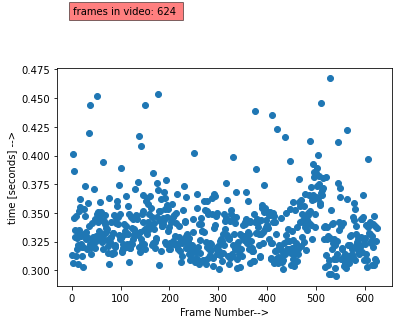

In [17]:
print("----------------------------------------------------------------------------------")
frames = vid_obj.get(cv2.CAP_PROP_FRAME_COUNT)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
seconds = round(frames / fps)
video_time = datetime.timedelta(seconds=seconds)
print(f"Frames per second of video--> {fps}")
print("----------------------------------------------------------------------------------")
print(f"video duration [hh:mm:ss]--> {video_time}")
print("----------------------------------------------------------------------------------")
print("Total number of frames in video:",frames)
print("----------------------------------------------------------------------------------")
print("Total time for dehazing video:",sum(y_time))
print("----------------------------------------------------------------------------------")
print("Average time for dehazing per frame:",sum(y_time)/len(y_time))
print("----------------------------------------------------------------------------------")
print("maximum processing time for a frame", max(y_time) )
print("----------------------------------------------------------------------------------")
print("minimum processing time for a frame", min(y_time) )
print("----------------------------------------------------------------------------------")
plt.scatter(x_fc,y_time)
plt.ylabel("time [seconds] -->")
plt.xlabel("Frame Number-->")
plt.text(3,0.523 , f'frames in video: { len(y_time) } ' , bbox=dict(facecolor='red', alpha=0.5))
plt.show()

# Quality Measurement

In [18]:
# sample size of random frames--> 
sample_size = 5

In [19]:
random_frames=[]
no_of_frames = vid_obj.get(cv2.CAP_PROP_FRAME_COUNT)

for i in range(sample_size):
    r=random.randint(1,int(no_of_frames))
    if r not in random_frames:
        random_frames.append(r)
        
print(random_frames)

[433, 78, 403, 503, 548]


In [20]:
def calculate_psnr(noisy_image, denoised_image):
    assert noisy_image.shape == denoised_image.shape, "Images must have the same shape"
    
    mse = np.mean((noisy_image - denoised_image) ** 2)
    max_pixel_value = np.max(noisy_image)
    psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)
    
    return psnr



In [21]:
def calculate_contrast_metrics1(image):
    # Converting the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #standard deviation
    sd = np.std(gray_image)
    
    # contrast measure
    cm = np.mean(np.abs(np.diff(gray_image)))
    
    return sd, cm


In [22]:
def calculate_contrast_metrics(image):
    # Converting the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # contrast measure
    cm = np.mean(np.abs(np.diff(gray_image)))
    
    return cm

In [23]:
#frames loader --> 
original_frame_cmS = []
dehazed_frame_cmS = []

for f in random_frames:
    original_image_path = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\extracted_frames', 'frame_'+str(f)+'.png')
    original_image = cv2.imread(original_image_path)
    dehazed_image_path =  os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames', 'frame_'+str(f)+'.png')
    dehazed_image = cv2.imread(dehazed_image_path)
   
   # original_sd, original_cm = calculate_contrast_metrics(original_image)
    original_cm = calculate_contrast_metrics(original_image)
   # dehazed_sd, dehazed_cm = calculate_contrast_metrics(dehazed_image)
    dehazed_cm = calculate_contrast_metrics(dehazed_image)
    
    original_frame_cmS.append(original_cm)
    dehazed_frame_cmS.append(dehazed_cm)
    
    print("Frame no.- " , f )
    print("Original Image | Contrast Measure: ", original_cm)
    print("Dehazed Image  | Contrast Measure: ", dehazed_cm)
    print("-----------------------------------------------------")

Frame no.-  433
Original Image | Contrast Measure:  58.851891417211895
Dehazed Image  | Contrast Measure:  59.72842481616583
-----------------------------------------------------
Frame no.-  78
Original Image | Contrast Measure:  61.18879817806342
Dehazed Image  | Contrast Measure:  62.82825449211588
-----------------------------------------------------
Frame no.-  403
Original Image | Contrast Measure:  60.808871808233455
Dehazed Image  | Contrast Measure:  61.53427518190416
-----------------------------------------------------
Frame no.-  503
Original Image | Contrast Measure:  52.460782525620985
Dehazed Image  | Contrast Measure:  58.06226622662266
-----------------------------------------------------
Frame no.-  548
Original Image | Contrast Measure:  56.86577596356127
Dehazed Image  | Contrast Measure:  59.050766699476966
-----------------------------------------------------


# X- axis

In [24]:
no_of_trials = []
for i in range(len(original_frame_cmS)):
    no_of_trials.append(i+1)

In [25]:
print(original_frame_cmS)
print(dehazed_frame_cmS)


[58.851891417211895, 61.18879817806342, 60.808871808233455, 52.460782525620985, 56.86577596356127]
[59.72842481616583, 62.82825449211588, 61.53427518190416, 58.06226622662266, 59.050766699476966]


# Comparision plot

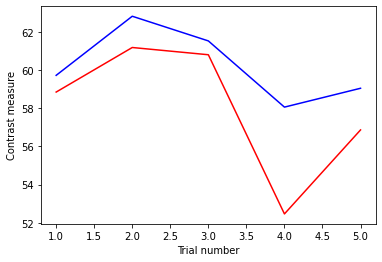

In [26]:
plt.plot(no_of_trials , original_frame_cmS,color="red")
plt.plot(no_of_trials , dehazed_frame_cmS, color="blue")

plt.ylabel("Contrast measure")
plt.xlabel("Trial number")
plt.show()